<a id="tercero"></a>
## 3. [Opcional] Cadenas de Markov
---
> *Dado que esta actividad es opcional, el puntaje obtenido si se realiza será equivalente a un bonus sobre el promedio final de notas de tareas.*

En esta sección emplearemos un modelo **no supervisado** especializado en secuencias, como lo son las cadenas de markov, para modelar series de tiempo, es decir una serie de registros (tı́picamente valores reales) regularmente indexados en el tiempo. Parea ello utilizaremos el dataset denominado “*international airline passengers*” [[5]](#refs). La tarea consiste en predecir el número de pasajeros (miles) en vuelos internacionales.


<img src="https://i.imgur.com/Fyf0LK6.png" title="Title text" width="80%" />

Los datos pueden ser descargados a través del siguiente __[link](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line)__. También están disponibles en Kaggle a través del siguiente __[link](https://www.kaggle.com/andreazzini/international-airline-passengers)__

Para la actividad se trabajará con la librería de *sklearn* para aprendizaje sobre secuencias HMM (*Hidden Markov Model*), también puede acudir a la documentación online a través del siguiente __[link](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#available-models)__.
```
pip install --upgrade hmmlearn
conda install -c omnia hmmlearn
```

>a) Escriba una función que cargue los datos, los divida en conjuntos de entrenamiento y de pruebas. En base a como trabajan las cadenas de markov ¿Es necesario escalar los datos?

In [1]:
import pandas as pd
name_f = "international-airline-passengers.csv"
dataframe = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)
dataframe[:] = dataframe[:].astype('float32')
X_train, X_test = dataframe[:96].values, dataframe[96:].values
dataframe.head

<bound method DataFrame.head of      International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0                                                112.0                             
1                                                118.0                             
2                                                132.0                             
3                                                129.0                             
4                                                121.0                             
5                                                135.0                             
6                                                148.0                             
7                                                148.0                             
8                                                136.0                             
9                                                119.0                             
10                                          

Se puede ver que durante los años se forma un periodo pero que este periodo va aumentando de valor a medida que pasan los años.

> b) Para resolver el problema defina un modelo de cadena de markov de primer orden con estados ocultos (*hidden markov model*) simple con un generador de datos osbervados que e distribuye normal $p(x_t|s_t)=\mathcal{N}(\mu_{s},\sigma_{s})$. Para evaluar mida la log-verosimilitud (*log-likelihood*) del modelo sobre el conjunto de entrenamiento y de pruebas. Comente

In [4]:
from hmmlearn import hmm
import numpy as np
np.random.seed(30)
n_state = 3
markov_model = hmm.GaussianHMM(n_components=n_state, n_iter=100)
markov_model.fit(X_train)
markov_model.score(X_train)
markov_model.score(X_test)

-462.6928527979635

> c) Analice cualitativamente lo que aprendió el modelo a través de las distribuciones de probabilidad de las observaciones para un estado oculto dado, esto es, $p(x_t|s_t)$, y las distribuciones de probabilidad de transición $p(s_{t+1}|s_t)$. Comente.

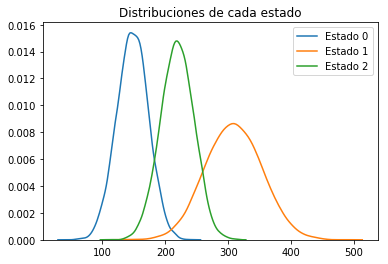

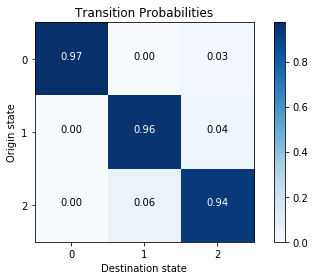

In [5]:
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
import itertools
for i in range(n_state):
    r = norm(markov_model.means_[i], np.sqrt( markov_model.covars_[i,0])).rvs(10000)
    sns.distplot(r,kde=True, hist=False,label="Estado "+str(i))
plt.legend()
plt.title("Distribuciones de cada estado")
plt.show()
def plot_state_matrix(cm, states,title='Transition Probabilities',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(states))
    plt.xticks(tick_marks, states)
    plt.yticks(tick_marks, states)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('Origin state')
    plt.xlabel('Destination state')
    plt.tight_layout()
plot_state_matrix(markov_model.transmat_,np.arange(n_state))

Se puede ver que la probabilidad de quedarse en el mismo estado es muy grande, por lo cual  suele predecir el modelo como igul a los meses anteriores.

> d) Gracias a que el modelo no predice un valor único, sino que una distribucipon de probabilidad (incerteza en cada valor continuo), realice un gráfico de ésto, es decir, visualice el intervalo de confianza en que el modelo predice en cada instante de tiempo, dado el estado oculto, y contrarréstelo con la secuencia original. Hágalo para el conjunto de entrenamiento y de pruebas

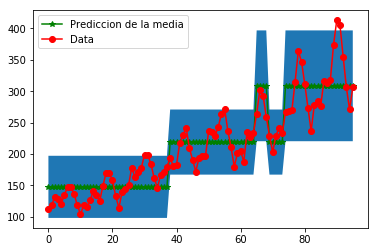

In [11]:
X_state = markov_model.predict(X_train) #predice el estado, no el valor
plt.fill_between(np.arange(X_train.shape[0]),markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0], markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0])
plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media")
plt.plot(X_train,'ro-',label="Data") #-- here put train or val
plt.legend()
plt.show()

> e) Dado que se ve que el problema no puede ser modelado de manera adecuada con 3 estados distintos (valores que puede tomar el estado oculto en cada instante de tiempo, $s_t$). Experimente con variar la cantidad de éstos  ¿Qué sucede si aumenta hasta tener la misma cantidad de estados que la cantidad de datos? Visualice lo que estime conveniente, además de medir el *log-likelihood* en cada conjunto.

In [12]:
n_states = np.arange(1,50)
markov_model = hmm.GaussianHMM(n_components=n_state, n_iter=100)
markov_model.fit(X_train)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=3, n_iter=100, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

> f) Debido a que el modelo no predice el valor continuo directamente, sino que predice el estado oculto de cada instante de tiempo, es necesario hacer un muestreo para obtener el valor continuo (o si desea, quedarse con la media). Realice este muestreo y evalúe la métrica de MSE (*Mean Square Error*) sobre el conjunto de pruebas.

In [13]:
X_state = markov_model.predict(X_test) #predice el estado, no el valor
X_output = norm( markov_model.means_[X_state], np.sqrt(markov_model.covars_[X_state][:,0]) ).rvs() #rvs is sample
from  sklearn.metrics import mean_squared_error as mse
mse(X_test, X_output)

19933.280536607159

> ¿Cambian mucho los resultados si se emplea una mezcla de gausianas como modelo para $p(x_t|s_t)$ en ves de que cada estado pertenezca a un único modelo Gausiano (distribución normal)?

In [14]:
from hmmlearn.hmm import GMMHMM
markov_model2 = GMMHMM(n_components=n_state, n_mix=3, n_iter=100)